In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from models import basemodel, non_norm, ResnetLayer, Resnet, Resnet_regression, basemodel_regression, build_resnet
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.nonparametric.kernel_regression import KernelReg
import pickle as pkl
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
# 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[3],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    except RuntimeError as e:
        # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

2023-10-17 03:06:33.021437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 03:06:33.175477: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 03:06:33.231696: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 03:06:33.994107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def train_dnn(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train_dnn_reg(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [
                    callback, 
                    # early_stopping
                    ]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train_regression(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [callback, early_stopping]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

# def heatmap(matrix, title, label):
#     save_path = 'plot/cm.png'
#     df=pd.DataFrame(matrix, index = label, columns = label)
#     plt.figure(figsize=(10,10))
#     sns.heatmap(df, annot=True, fmt = 'd')
#     plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
#     plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
#     plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
#     plt.xlabel("Prediction",position = (0.5,1.0+0.05))
#     plt.ylabel("Ground Truth")
#     plt.title(title)
#     plt.savefig('cm.png', format='png', dpi=300)

In [3]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [4]:
def file_sort(path):
    file_list = os.listdir(path)
    for file in file_list:
        if os.path.isfile(os.path.join(path, file)):
            tmp = file.split('_')
            tmp[0] = tmp[0].zfill(2)
            createFolder('./'+path+'/' + tmp[0])
            shutil.move('./'+path+'/' + file, './'+path+'/' + tmp[0] + '/' + file)

In [5]:
def file_load(path):
    # data = list()
    file_list = os.listdir(path)
    data = None
    for file in file_list:
        file_path = os.path.join(path,file)
        if os.path.isfile(file_path):
            temp = np.load(file_path)
            if data is not None:
                data = np.concatenate((data, temp), axis = 0)
            else:
                data = temp
            # data.append(temp)
    return np.squeeze(data, axis = 1)

In [6]:
folder_path_cylinder = 'counting_cylinder'
folder_path_disk = 'counting_disk'
# folder_path = 'counting'
# folder_path = 'countingdatasmall'

In [7]:
folder_list_cylinder = sorted(os.listdir(folder_path_cylinder))
folder_list_disk = sorted(os.listdir(folder_path_disk))

In [8]:
folder_list_cylinder[2]

'02'

In [9]:
cylinder_data = None
def data_load(folder_path):
    data = None
    folder_list = sorted(os.listdir(folder_path))
    for folder in folder_list:
        temp_path = os.path.join(folder_path,folder)
        if data is not None:
            data = np.concatenate((data, file_load(temp_path)), axis = 0) 
        else:
            data = file_load(temp_path)
    return data

In [10]:
cylinder_data = data_load(folder_path_cylinder)
disk_data = data_load(folder_path_disk)

In [11]:
reshaped_data = {
    '00' : np.expand_dims(cylinder_data, axis = 2),
    '01' : np.expand_dims(disk_data, axis = 2)
}

In [20]:
# # 서브플롯 그리기
# num_profiles = len(range_fft_dict)
# plt.figure(figsize=(10, 5 * num_profiles))

# for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
#     plt.subplot(num_profiles, 1, idx)
#     plt.imshow(10 * np.log10(np.abs(profile)), aspect='auto', cmap='jet', interpolation='none')
#     # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
#     plt.colorbar(label="dB")
#     plt.xlabel("Range Bin")
#     plt.ylabel("Pulse Number")
#     plt.title(f"Range Profiles: {key}")

# plt.tight_layout()
# plt.show()

In [21]:
# # 그래프 그리기
# num_profiles = len(range_fft_dict)

# for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     Z = 10 * np.log10(np.abs(profile))
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

In [22]:
# num_profiles = len(reshaped_data)

# for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     # Z = 10 * np.log10(np.abs(profile))
#     Z = np.abs(profile)
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

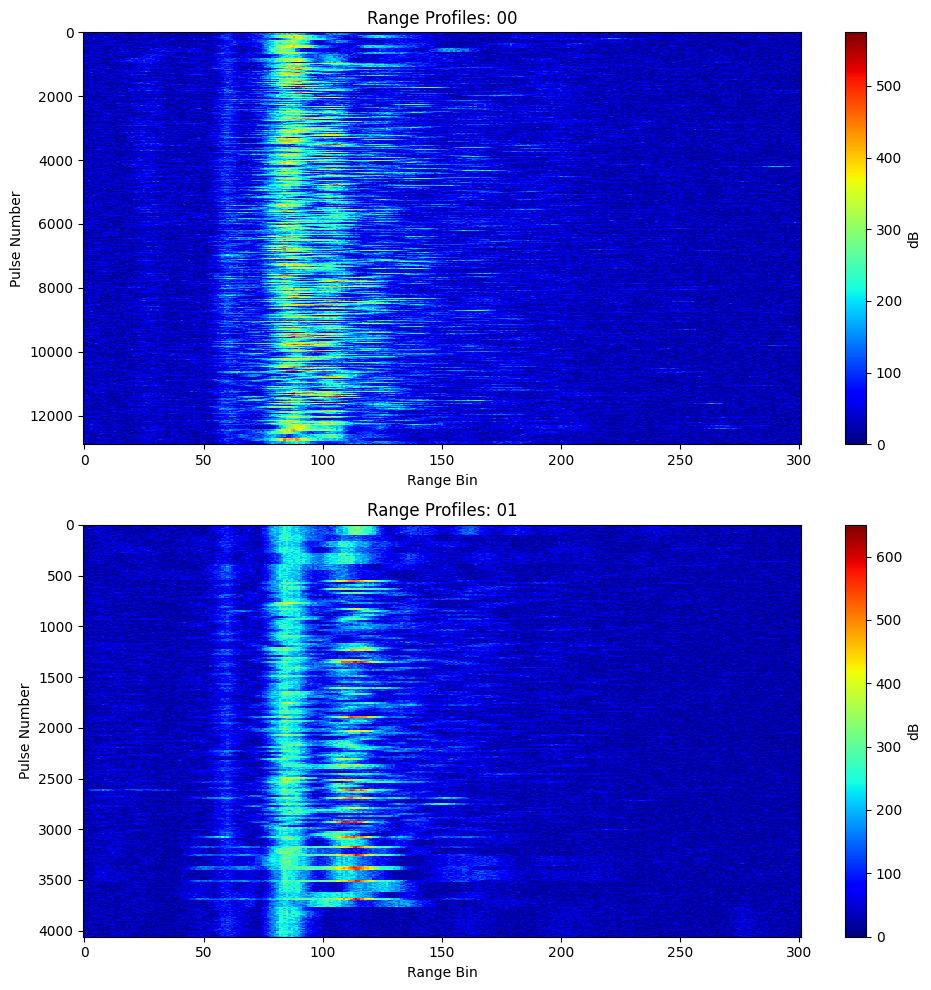

In [31]:
# 서브플롯 그리기
num_profiles = len(reshaped_data)
plt.figure(figsize=(10, 5 * num_profiles))

for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
    plt.subplot(num_profiles, 1, idx)
    plt.imshow(profile, aspect='auto', cmap='jet', interpolation='none')
    # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
    plt.colorbar(label="dB")
    plt.xlabel("Range Bin")
    plt.ylabel("Pulse Number")
    plt.title(f"Range Profiles: {key}")

plt.tight_layout()
plt.show()

In [12]:
def make_dataset(data_dict):
    # x = list()
    y = list()
    x = None
    for key, data in data_dict.items():
        if x is None:
            x = data
        else:
            x = np.concatenate((x, data), axis = 0)
        for i in range(data.shape[0]):
            y.append(to_categorical(int(key), num_classes=len(data_dict)))
    # print(x.shape)
    y = np.array(y)
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [13]:
# X_train, X_test, Y_train, Y_test = make_dataset(range_fft_dict)
# X_train, X_test  = 10 * np.log10(X_train), 10 * np.log10(X_test)
X_train, X_test, Y_train, Y_test = make_dataset(reshaped_data)
# X_train, X_test = np.expand_dims(X_train, axis = 2), np.expand_dims(X_test, axis = 2)

2023-10-17 03:06:54.945634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 03:06:55.594149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


X shape :  (13568, 301, 1)
Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_layer (ResnetLayer)  multiple                  24484     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  2465920   
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  2080      
                                                                 
 dense_3 (Dense)             mult

2023-10-17 03:06:58.404335: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-17 03:06:58.577523: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


423/424 [============================>.] - ETA: 0s - loss: 1.0683 - accuracy: 0.8791 - categorical_crossentropy: 1.0683

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 13s 22ms/step - loss: 1.0666 - accuracy: 0.8791 - categorical_crossentropy: 1.0666 - val_loss: 0.3368 - val_accuracy: 0.8965 - val_categorical_crossentropy: 0.3368
Epoch 2/200
424/424 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9469 - categorical_crossentropy: 0.1473

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 10s 23ms/step - loss: 0.1473 - accuracy: 0.9469 - categorical_crossentropy: 0.1473 - val_loss: 0.0844 - val_accuracy: 0.9679 - val_categorical_crossentropy: 0.0844
Epoch 3/200
423/424 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9693 - categorical_crossentropy: 0.0880

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 9s 21ms/step - loss: 0.0879 - accuracy: 0.9693 - categorical_crossentropy: 0.0879 - val_loss: 0.0623 - val_accuracy: 0.9746 - val_categorical_crossentropy: 0.0623
Epoch 4/200
422/424 [============================>.] - ETA: 0s - loss: 0.0580 - accuracy: 0.9789 - categorical_crossentropy: 0.0580

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 9s 22ms/step - loss: 0.0579 - accuracy: 0.9789 - categorical_crossentropy: 0.0579 - val_loss: 0.0264 - val_accuracy: 0.9891 - val_categorical_crossentropy: 0.0264
Epoch 5/200
422/424 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9869 - categorical_crossentropy: 0.0369

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 9s 22ms/step - loss: 0.0368 - accuracy: 0.9869 - categorical_crossentropy: 0.0368 - val_loss: 0.0293 - val_accuracy: 0.9894 - val_categorical_crossentropy: 0.0293
Epoch 6/200
424/424 [==============================] - 5s 12ms/step - loss: 0.0547 - accuracy: 0.9828 - categorical_crossentropy: 0.0547 - val_loss: 0.0479 - val_accuracy: 0.9858 - val_categorical_crossentropy: 0.0479
Epoch 7/200
422/424 [============================>.] - ETA: 0s - loss: 0.0332 - accuracy: 0.9879 - categorical_crossentropy: 0.0332

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 9s 21ms/step - loss: 0.0331 - accuracy: 0.9879 - categorical_crossentropy: 0.0331 - val_loss: 0.0280 - val_accuracy: 0.9915 - val_categorical_crossentropy: 0.0280
Epoch 8/200
424/424 [==============================] - 6s 15ms/step - loss: 0.0297 - accuracy: 0.9915 - categorical_crossentropy: 0.0297 - val_loss: 0.0387 - val_accuracy: 0.9861 - val_categorical_crossentropy: 0.0387
Epoch 9/200
424/424 [==============================] - 7s 16ms/step - loss: 0.0325 - accuracy: 0.9896 - categorical_crossentropy: 0.0325 - val_loss: 0.0313 - val_accuracy: 0.9897 - val_categorical_crossentropy: 0.0313
Epoch 10/200
424/424 [==============================] - 7s 16ms/step - loss: 0.0211 - accuracy: 0.9931 - categorical_crossentropy: 0.0211 - val_loss: 0.0544 - val_accuracy: 0.9882 - val_categorical_crossentropy: 0.0544
Epoch 11/200
423/424 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.9926 - categorical_crossentropy: 0.0239

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 9s 22ms/step - loss: 0.0238 - accuracy: 0.9926 - categorical_crossentropy: 0.0238 - val_loss: 0.0243 - val_accuracy: 0.9932 - val_categorical_crossentropy: 0.0243
Epoch 12/200
424/424 [==============================] - 7s 16ms/step - loss: 0.0254 - accuracy: 0.9926 - categorical_crossentropy: 0.0254 - val_loss: 0.1878 - val_accuracy: 0.9614 - val_categorical_crossentropy: 0.1878
Epoch 13/200
424/424 [==============================] - 7s 16ms/step - loss: 0.0913 - accuracy: 0.9849 - categorical_crossentropy: 0.0913 - val_loss: 0.0512 - val_accuracy: 0.9870 - val_categorical_crossentropy: 0.0512
Epoch 14/200
423/424 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9961 - categorical_crossentropy: 0.0126

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 10s 24ms/step - loss: 0.0125 - accuracy: 0.9961 - categorical_crossentropy: 0.0125 - val_loss: 0.0109 - val_accuracy: 0.9965 - val_categorical_crossentropy: 0.0109
Epoch 15/200
424/424 [==============================] - 7s 16ms/step - loss: 0.0068 - accuracy: 0.9976 - categorical_crossentropy: 0.0068 - val_loss: 0.0198 - val_accuracy: 0.9962 - val_categorical_crossentropy: 0.0198
Epoch 16/200
424/424 [==============================] - 7s 16ms/step - loss: 0.0129 - accuracy: 0.9959 - categorical_crossentropy: 0.0129 - val_loss: 0.0368 - val_accuracy: 0.9912 - val_categorical_crossentropy: 0.0368
Epoch 17/200
424/424 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9978 - categorical_crossentropy: 0.0075

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 10s 23ms/step - loss: 0.0075 - accuracy: 0.9978 - categorical_crossentropy: 0.0075 - val_loss: 0.0131 - val_accuracy: 0.9968 - val_categorical_crossentropy: 0.0131
Epoch 18/200
424/424 [==============================] - 7s 16ms/step - loss: 0.0093 - accuracy: 0.9972 - categorical_crossentropy: 0.0093 - val_loss: 0.0217 - val_accuracy: 0.9956 - val_categorical_crossentropy: 0.0217
Epoch 19/200
424/424 [==============================] - 7s 16ms/step - loss: 0.0280 - accuracy: 0.9929 - categorical_crossentropy: 0.0280 - val_loss: 0.0336 - val_accuracy: 0.9929 - val_categorical_crossentropy: 0.0336
Epoch 20/200
424/424 [==============================] - 7s 15ms/step - loss: 0.0125 - accuracy: 0.9963 - categorical_crossentropy: 0.0125 - val_loss: 0.0463 - val_accuracy: 0.9935 - val_categorical_crossentropy: 0.0463
Epoch 21/200
424/424 [==============================] - 7s 16ms/step - loss: 0.0100 - accuracy: 0.9973 - categorical_crossentropy: 0.010

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 8s 20ms/step - loss: 0.0037 - accuracy: 0.9989 - categorical_crossentropy: 0.0037 - val_loss: 0.0119 - val_accuracy: 0.9971 - val_categorical_crossentropy: 0.0119
Epoch 60/200
424/424 [==============================] - 5s 11ms/step - loss: 0.0015 - accuracy: 0.9996 - categorical_crossentropy: 0.0015 - val_loss: 0.0236 - val_accuracy: 0.9959 - val_categorical_crossentropy: 0.0236
Epoch 61/200
424/424 [==============================] - 4s 11ms/step - loss: 0.0049 - accuracy: 0.9985 - categorical_crossentropy: 0.0049 - val_loss: 0.0134 - val_accuracy: 0.9965 - val_categorical_crossentropy: 0.0134
Epoch 62/200
424/424 [==============================] - 4s 11ms/step - loss: 0.0071 - accuracy: 0.9984 - categorical_crossentropy: 0.0071 - val_loss: 0.0199 - val_accuracy: 0.9959 - val_categorical_crossentropy: 0.0199
Epoch 63/200
424/424 [==============================] - 5s 11ms/step - loss: 0.0045 - accuracy: 0.9990 - categorical_crossentropy: 0.0045

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 8s 19ms/step - loss: 2.1841e-04 - accuracy: 0.9999 - categorical_crossentropy: 2.1841e-04 - val_loss: 0.0117 - val_accuracy: 0.9976 - val_categorical_crossentropy: 0.0117
Epoch 65/200
424/424 [==============================] - 4s 10ms/step - loss: 3.8680e-05 - accuracy: 1.0000 - categorical_crossentropy: 3.8680e-05 - val_loss: 0.0124 - val_accuracy: 0.9971 - val_categorical_crossentropy: 0.0124
Epoch 66/200
424/424 [==============================] - 5s 11ms/step - loss: 2.0189e-05 - accuracy: 1.0000 - categorical_crossentropy: 2.0189e-05 - val_loss: 0.0134 - val_accuracy: 0.9971 - val_categorical_crossentropy: 0.0134
Epoch 67/200
424/424 [==============================] - 5s 11ms/step - loss: 0.0184 - accuracy: 0.9974 - categorical_crossentropy: 0.0184 - val_loss: 0.0370 - val_accuracy: 0.9870 - val_categorical_crossentropy: 0.0370
Epoch 68/200
424/424 [==============================] - 4s 11ms/step - loss: 0.0042 - accuracy: 0.9985 - categori

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 8s 19ms/step - loss: 1.6992e-04 - accuracy: 0.9999 - categorical_crossentropy: 1.6992e-04 - val_loss: 0.0094 - val_accuracy: 0.9982 - val_categorical_crossentropy: 0.0094
Epoch 103/200
424/424 [==============================] - 5s 11ms/step - loss: 1.8691e-04 - accuracy: 0.9999 - categorical_crossentropy: 1.8691e-04 - val_loss: 0.0141 - val_accuracy: 0.9979 - val_categorical_crossentropy: 0.0141
Epoch 104/200
424/424 [==============================] - 5s 11ms/step - loss: 2.9628e-04 - accuracy: 0.9999 - categorical_crossentropy: 2.9628e-04 - val_loss: 0.0124 - val_accuracy: 0.9979 - val_categorical_crossentropy: 0.0124
Epoch 105/200
424/424 [==============================] - 5s 11ms/step - loss: 8.1347e-05 - accuracy: 1.0000 - categorical_crossentropy: 8.1347e-05 - val_loss: 0.0142 - val_accuracy: 0.9982 - val_categorical_crossentropy: 0.0142
Epoch 106/200
422/424 [============================>.] - ETA: 0s - loss: 1.2493e-05 - accuracy: 1.0000

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 9s 20ms/step - loss: 1.2435e-05 - accuracy: 1.0000 - categorical_crossentropy: 1.2435e-05 - val_loss: 0.0135 - val_accuracy: 0.9985 - val_categorical_crossentropy: 0.0135
Epoch 107/200
424/424 [==============================] - 5s 11ms/step - loss: 3.5433e-06 - accuracy: 1.0000 - categorical_crossentropy: 3.5433e-06 - val_loss: 0.0140 - val_accuracy: 0.9985 - val_categorical_crossentropy: 0.0140
Epoch 108/200
424/424 [==============================] - 5s 12ms/step - loss: 6.5006e-06 - accuracy: 1.0000 - categorical_crossentropy: 6.5006e-06 - val_loss: 0.0138 - val_accuracy: 0.9982 - val_categorical_crossentropy: 0.0138
Epoch 109/200
424/424 [==============================] - 5s 11ms/step - loss: 3.5934e-06 - accuracy: 1.0000 - categorical_crossentropy: 3.5934e-06 - val_loss: 0.0156 - val_accuracy: 0.9982 - val_categorical_crossentropy: 0.0156
Epoch 110/200
424/424 [==============================] - 5s 12ms/step - loss: 9.3803e-07 - accuracy: 1

INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


INFO:tensorflow:Assets written to: ./model/resnet_classification/assets


424/424 [==============================] - 10s 23ms/step - loss: 1.9629e-04 - accuracy: 0.9999 - categorical_crossentropy: 1.9629e-04 - val_loss: 0.0033 - val_accuracy: 0.9994 - val_categorical_crossentropy: 0.0033
Epoch 188/200
424/424 [==============================] - 6s 15ms/step - loss: 4.0391e-05 - accuracy: 1.0000 - categorical_crossentropy: 4.0391e-05 - val_loss: 0.0028 - val_accuracy: 0.9991 - val_categorical_crossentropy: 0.0028
Epoch 189/200
424/424 [==============================] - 4s 11ms/step - loss: 4.8192e-06 - accuracy: 1.0000 - categorical_crossentropy: 4.8192e-06 - val_loss: 0.0028 - val_accuracy: 0.9988 - val_categorical_crossentropy: 0.0028
Epoch 190/200
424/424 [==============================] - 5s 11ms/step - loss: 9.4717e-04 - accuracy: 0.9996 - categorical_crossentropy: 9.4717e-04 - val_loss: 0.0248 - val_accuracy: 0.9976 - val_categorical_crossentropy: 0.0248
Epoch 191/200
424/424 [==============================] - 5s 11ms/step - loss: 0.0035 - accuracy: 0.99

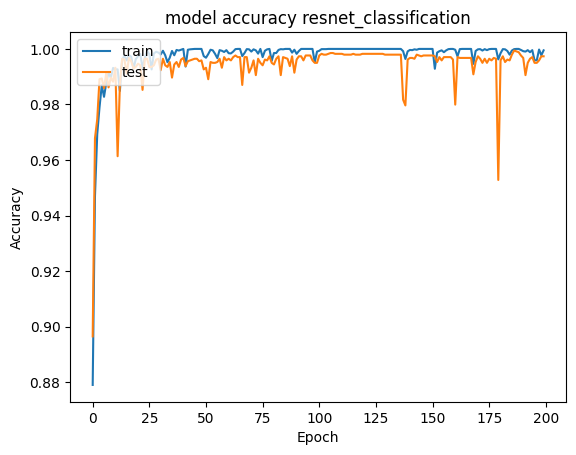

In [14]:
# non_norm_model = non_norm(len(range_fft_dict))

# base model
# model = basemodel(len(range_fft_dict))

# Resnet
filter_in_list = [1, 32]
filter_out_list = [32, 64]
kernel_size = 3
# model = build_resnet(filter_in_list = filter_in_list, filter_out_list = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
model = Resnet(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
history = train(model = model, X = X_train, Y = Y_train, test_X = X_test, test_Y = Y_test, cp_path = 'resnet_classification', Epoch=200)